In [20]:
from photutils.detection import IRAFStarFinder
from photutils.detection import DAOStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOPhotPSFPhotometry, FittableImageModel, DAOGroup, prepare_psf_model, extract_stars, EPSFModel
from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D, SExtractorBackground
from photutils.aperture import CircularAperture
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.io import fits
from astropy.wcs import WCS
#from PythonPhot import aper, getpsf, group, dao_value
import numpy as np
import os
#from PythonPhot.PythonPhot import aper, getpsf, rdpsf, group
from astropy.table import QTable
from photutils import BasicPSFPhotometry, MedianBackground
from astropy.stats import SigmaClip
from astropy.nddata import Cutout2D
from matplotlib.colors import LogNorm
from astropy.visualization import imshow_norm, MinMaxInterval, SqrtStretch, ImageNormalize, simple_norm
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from scipy.interpolate import interp1d
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
from lmfit.models import LinearModel, GaussianModel
from scipy.stats import mode, norm
from astropy.wcs import WCS
import glob
#from astroquery.vizier import Vizier
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
#import pyregion
from astropy.coordinates import Angle
from skimage.transform import rescale
from skimage.filters import threshold_local
from astropy.modeling import models, fitting
from numpy import exp, loadtxt, pi, sqrt
from scipy.signal import convolve2d, medfilt2d
from astropy.modeling.functional_models import Gaussian2D
from astropy.convolution import convolve, Gaussian2DKernel
from scipy.ndimage import gaussian_filter
import scipy
import scipy.io as sio
from astropy.table import QTable, Table, Column
import matplotlib.patches as patches
import pandas as pd
from scipy.io import readsav
import json
from regions import Regions #read_ds9, write_ds9
import csv
from sklearn.cluster import KMeans
from sklearn import cluster
#from matplotlib_venn import venn2, venn2_circles, venn2_unweighted, venn3, venn3_circles
import matplotlib.image as mpimg
import matplotlib.patches as patch
from matplotlib.ticker import MultipleLocator
import math
from scipy.optimize import curve_fit
from astropy.visualization.stretch import AsinhStretch
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
#from mpl_toolkits.axes_grid1.colorbar import colorbar
import random
import math
import matplotlib.font_manager as font_manager
import time
from pathlib import Path
from astropy.nddata.utils import add_array
from regions import Regions
from scipy import stats
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
from PIL import Image
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)
from pyds9 import ds9
from photutils.background import Background2D, MedianBackground
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from scipy.integrate import quad

In [2]:
hdr = fits.getheader('ISF_Mosaic_Trial5_drz_sci.fits')
im  = fits.getdata('ISF_Mosaic_Trial5_drz_sci.fits')
wcs = WCS(hdr)

In [3]:
def write_regf(ra, dec, fname, c, text, r=None, update=False):
    """
    fname - file name to be written
    c - region color
    """
    xx, yy = ra, dec
    text = np.array(text, dtype=str)
    if r==None:
        r =25
    else:
        r=r
    if update == True:
        with open(fname) as unt:
            lines = unt.readlines()
        with open(fname, 'w') as unt:    
            unt.writelines(lines)

            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')
    else:
        with open(fname, 'w') as unt:
            unt.write('fk5')
            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')

In [4]:
def norm_logistic_reg(x, mu, sig):
    w = 1/(1+np.exp(-((x-mu)/sig)))
    return w

In [24]:
def r_times_logistic_reg(x, m, s):
    w = x/(1+np.exp(-((x-m)/s)))
    return w

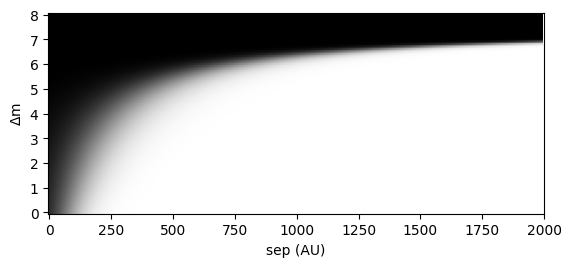

In [5]:
frac_mtx = np.loadtxt('Fraction_dm_sep_array.txt')
fig, ax = plt.subplots()
plt.imshow(frac_mtx, origin='lower', cmap='gray')
locs = plt.xticks()
plt.xticks(locs[0][1::], np.arange(0, 2001, 250))
locs = plt.yticks()
plt.yticks(locs[0][1:-1], np.arange(0, 9, 1))
plt.xlabel('sep (AU)')
plt.ylabel('$\Delta$m');

In [6]:
df_params = pd.read_csv('mu_sig_params.csv')
mu, sig = np.array(df_params['mu']), np.array(df_params['sig'])
df_flame = pd.read_csv('dm_sep_flame.csv')
sep_flame, dm_flame = np.array(df_flame['sep']), np.array(df_flame['dm'])

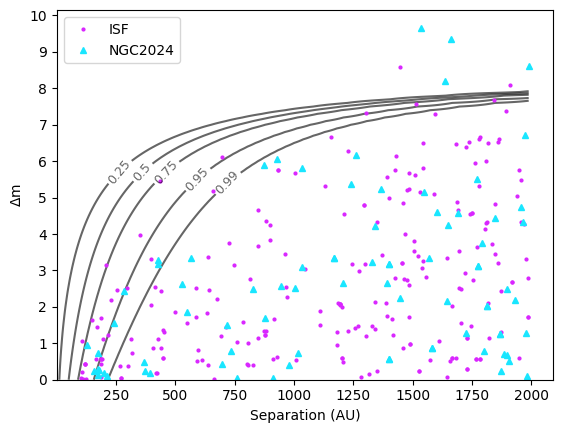

In [25]:
dms = np.arange(0, 8.01, 1/10)
seps = np.arange(50, 2050., 100/10)
dm_mtx, sep_mtx = np.indices((len(dms), len(seps)))
#sep_mtx = np.tile(np.arange(0, 2000.1, 0.1), )
dm_mtx, sep_mtx = (np.flip(dm_mtx,0))/10, 100*(sep_mtx+5)/10
frac_mtx = np.zeros(dm_mtx.shape)
n_dm = len(dms)
for i in range(len(mu)):
    frac_mtx[i, :] =  norm_logistic_reg(seps, mu[i], sig[i])

cmap = plt.cm.cool
category_colors = plt.colormaps['cool'](
        np.linspace(0.10, 0.85, 6))

fig, ax = plt.subplots()
#plt.imshow(frac_mtx, origin='lower', cmap='Greys_r', aspect="auto")
#colors=[category_colors[0]]

c25 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.25], colors='k', alpha=0.6)
c50 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.50], colors='k', alpha=0.6)
c75 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.75], colors='k', alpha=0.6)
c95 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.95], colors='k', alpha=0.6)
c99 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.99], colors='k', alpha=0.6)

xt = ax.get_xticks()
ax.set_xticks(xt[1::], np.round(xt[1::]*100/10).astype(int))
yt = ax.get_yticks()
ax.set_yticks(yt[1:-1], np.round((yt[1:-1])/10).astype(int))

manual_locations = [(20, 60)]
plt.clabel(c25, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(30, 60)]
plt.clabel(c50, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(40, 60)]
plt.clabel(c75, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(50, 60)]
plt.clabel(c95, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(60, 60)]
plt.clabel(c99, fontsize=9, inline=1, manual=manual_locations)

ax.set_xlabel('Separation (AU)')
ax.set_ylabel('$\Delta$m')


ra_cat, dec_cat, m_cat, i_yso = ra_f2, dec_f2, m_f2, i_yso
N_total = len(i_yso)
N_cand, N_cont = 0, 0
r1_comp = 100
r2_comp = 2000
r1_cont = 2000
r2_cont = 5000

#Making a catalog object using all sources
c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
              distance=390.*u.pc, frame='fk5')

ra_yso  = ra_cat[i_yso]
dec_yso = dec_cat[i_yso]
m_yso   = m_cat[i_yso]

i_tested = np.array([])
N_cand   = np.array([])

d_comp = np.array([])
dm_comp = np.array([])

for i in range(N_total):
    #Making a catalog object using YSO
    c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
    sep_     = c2.separation(c1).arcsec*400.
    i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
    n_obj    = len(i_obj_)

    if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
        ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
        dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
        m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array

        i_prim, = np.where(m_sys==np.min(m_sys))
        i_comp, = np.where(m_sys!=np.min(m_sys))
        N_cand  = N_cand + len(i_comp)
        ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
        ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
        m_prim = m_sys[i_prim]
        c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')

        c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
        sep_comp = c_comp.separation(c_prim).arcsec*400.
        #ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
        d_comp = np.append(d_comp, sep_comp)
        dm_comp = np.append(dm_comp, np.abs((m_sys[i_comp]-m_prim)))
ax.plot(d_comp/10, dm_comp*10, '.', c=category_colors[5], ms=4, label='ISF')
ax.plot(sep_flame/10, dm_flame*10, '^', c=category_colors[0], ms=4, label='NGC2024')
#ax.set_ylim(0, 100)
#ax.set_yticks(np.arange(0, 11, 1))
#yticks = ax.get_yticks()

ax.set_yticks(np.arange(0, 110, 10), np.arange(0, 11, 1));
ax.legend()

In [17]:
df_final = pd.read_csv('dash_rereduce_removed_combined_with_rereduceII_with_VISION.csv')
df_final2 = df_final
ra_f2 = np.array(df_final2['RA_d'])
dec_f2 = np.array(df_final2['DEC_d'])
m_f2 = np.array(df_final2['MAG_d'])
me_f2 = np.array(df_final2['MAG_d_unc'])
h_f2 = np.array(df_final2['H_v'])
he_f2 = np.array(df_final2['He_v'])
k_f2 = np.array(df_final2['Ks_v'])
ke_f2 = np.array(df_final2['Kse_v'])
fwhm_f2 = np.array(df_final2['FWHM_d'])
rsat_f2 = np.array(df_final2['R_SAT_d'])
clas_f2 = np.array(df_final2['class'], dtype=str)

yso_clas = np.array(['protostars', 'disks', 'td', 'nd_proto_faint'])
i_yso, = np.where(np.isin(clas_f2, yso_clas))

In [21]:
def CF(ra_cat, dec_cat, m_cat, i_yso):
#ra_cat, dec_cat, m_cat, i_yso = ra_Dcat, dec_Dcat, m_Dcat, i_Dyso
    N_total = len(i_yso)
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=390.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    d_mag = np.array([])
    dist = np.array([])
    fig, ax = plt.subplots()
    for i in range(N_total):
        #Making a catalog object using YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*400.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
        n_obj    = len(i_obj_)
        
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            N_cand  = N_cand + len(i_comp)
            ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
            ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
            m_prim = m_sys[i_prim]
            c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')
        
            c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
            sep_comp = c_comp.separation(c_prim).arcsec*400.
            #ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
            
            #making a new cat obj with the dimmest objects in the system
            c3       = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, 
                                distance=400.*u.pc, frame='fk5')
            sep      = c2.separation(c3).arcsec*400.
            
            i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
            N_cont_init = np.append(N_cont_init, len(i_cont))
            n_cont = 0
            for j in range(len(i_cont)):
                delta_m = m_cat[i_cont[j]]-m_prim
                dm_ind  = int(np.abs(10*np.round(delta_m, 1)))
                if dm_ind>80:
                    mu_, sig_ = 0, 0
                    R_ = 0
                else:
                    mu_  = mu[dm_ind]
                    sig_ = sig[dm_ind]
                    I  = quad(r_times_logistic_reg, 100, 1000, args=(mu_, sig_))
                    R_ = 2*np.pi * I[0] / (np.pi*(5000**2 - 2000**2))
                    R  = np.append(R, R_)
                    d_mag=np.append(d_mag,dm_ind)
                    R_unc   = np.append(R_unc, I[1])
                    dist = np.append(dist, sep[i_cont[j]])
                n_cont  = n_cont + R_
                #if n_cont > 0.5:
                #    ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
            N_cont_corr = np.append(N_cont_corr, n_cont)
            N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                          len(i_cont)*(1000**2-100**2)/(5000**2-2000**2))
            #if i==0:
            #    print(N_comp.shape)
            N_comp = N_comp + (len(i_comp) - n_cont)
            
    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    for i in range(len(dist)):
        ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(100*np.round(R[i], 3))])           
    print('N_cand: ', N_cand)
    print('N_cont within 200-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 200-5000: ', np.sum(N_cont_corr))
    print('N_comp: ', N_comp)
    print('CF ('+str(N_total)+'): ', N_comp/N_total)
    return d_mag, R, dist

N_cand:  93
N_cont within 200-5000 (before correction):  6.458571428571428
N_cont within 200-5000:  5.68166555548629
N_comp:  87.31833444451371
CF (671):  0.13013164596797872


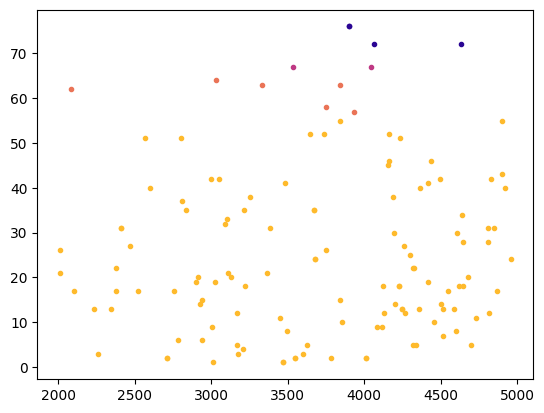

In [22]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_yso)

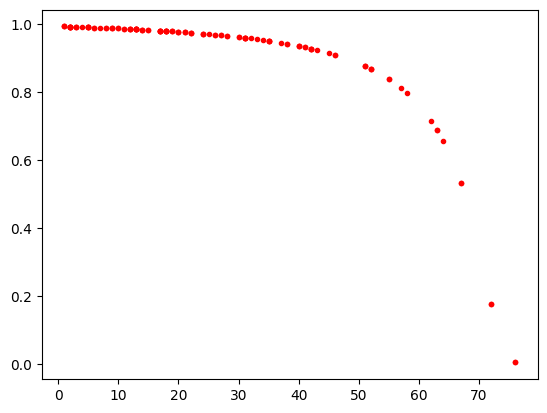

In [362]:
plt.subplot()
plt.plot(dmag, R/(1000**2-100**2)*(5000**2-2000**2), '.r')

--------------
